# Spectrogram
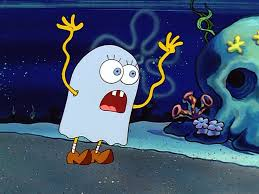

We will use some data recorded with a bottom moored ADCP (Argonaut XR), from the Rio Grande Pilots.  
The date were processed and available in a ASCII file. 

In [24]:
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(r'd:\guto\gpython\pytools')
import vector_tools as vt  #package with vector manipulation utilities. Available by request.

In [47]:
# loading the data... 

with open('dados_ADCP_praticagem_julho2022.txt') as io:
    lines = io.readlines()
    
len(lines)

8930

The velocity are in 'knots'  
1 knot = 0.51444 m/s  
I guess, the direction is corrected for magnetic declination!?
  
After assess the data, find out that the data is not 'homogenous'... the number of columns changes. 

In [48]:
time = []
data = []
g_ncols = []
for i, li in enumerate(lines[1:]):
    liq = li.split()
    
    numbers = [float(x) for x in liq[2:]]
    ncols = len(numbers)
    g_ncols.append(len(numbers))
    if ncols == 21:
        data.append(numbers)
        time.append(parse(liq[0] + ' ' + liq[1], dayfirst=True))
    
time = np.array(time)
data = np.array(data)

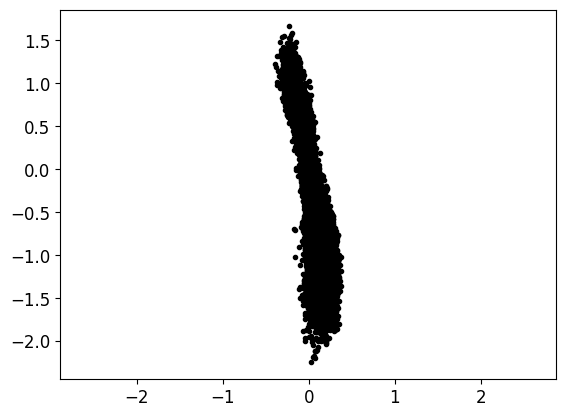

In [52]:
level = data[:,-1]

# to separate the direction and speed from the data
i_dir = np.arange(0, 20, 2)

speed = data[:,i_dir+1] * 0.51444
direction = data[:,i_dir]

#  converting to cartesian
u, v = vt.polar2cart(speed, direction)

# checking!
plt.plot(u, v, 'k.')
plt.axis('equal')
plt.show()

# the components is alredy aligned to North/South axis... no need of rotation!

In [34]:
# depth averaging the longitudinal component of the currents
vm = np.mean(v, axis=1)

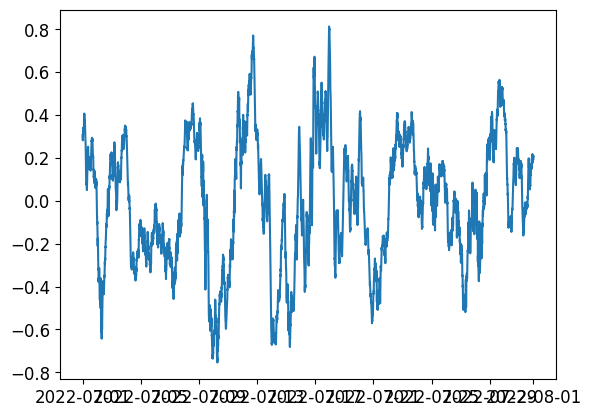

In [53]:
# checking the level
plt.plot(time, level)

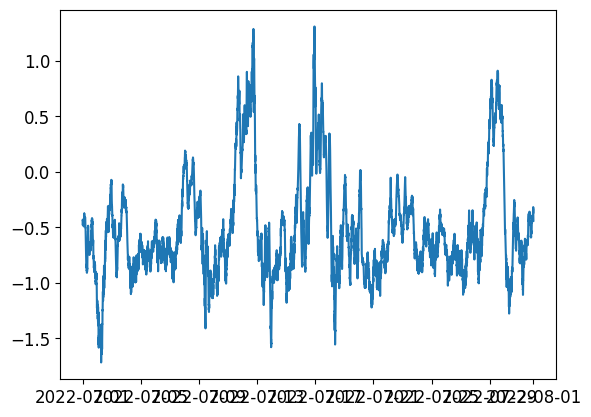

In [54]:
# checking the currents
plt.plot(time, vm)

In [55]:
# Do the spectral analysis... copied from someone else.. Stackoverflow.
def ghost(signal, sampling_interval):
    sampling_frequency = 1/sampling_interval
    samples = len(signal)

    # perform the Fourier Transform
    Fourier_transform = np.fft.fft(signal) / samples

    # get the first half of the trasnform
    Fourier_transform = Fourier_transform[:(int(samples/2))]

    values = np.arange(int(samples/2))
    time_period = samples / sampling_frequency
    frequencies = values / time_period

    PowerSpectralDensity = abs(Fourier_transform)
    
    return frequencies, PowerSpectralDensity

Perform the spectral analyis on the currents and level    
The sampling interval is 5 minutes, or 1/12 hour.
  
!!! --> I didn't check for the homogeinity :-(   

In [56]:
f1, d1 = ghost(vm, 1/12)
f2, d2 = ghost(nivel, 1/12)

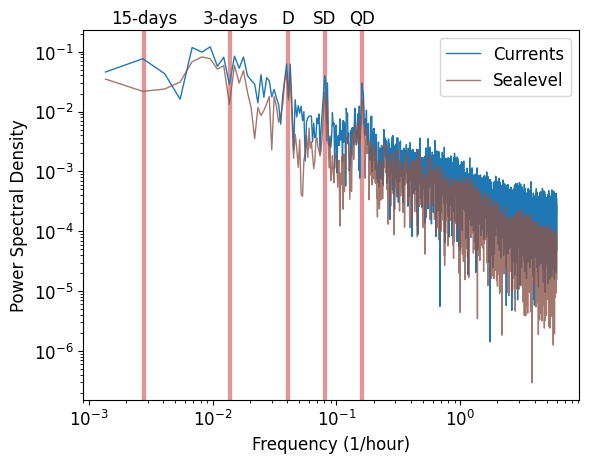

In [46]:
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots()

ax.plot(f1[1:], d1[1:], zorder=2, lw=1, label='Currents')
ax.plot(f2[1:], d2[1:], zorder=2, color='tab:brown', lw=1, alpha=0.8, label='Sealevel')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

ax.set_xlabel('Frequency (1/hour)')
ax.set_ylabel('Power Spectral Density')

Tl = ['QD', 'SD', 'D', '3-days', '15-days']
T = np.array([6.2, 12.4, 24.8, 24*3, 24*15])

for i,t in enumerate(T):
    ax.axvline(1/t, color='tab:red', lw=3, zorder=0, alpha=0.5)
    ax.text(1/t, 0.3, Tl[i], fontsize=12, ha='center')